### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [ ]:
# You will need to download any word embeddings required for your code, e.g.:

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch
%pip install transformers

In [1]:
# Download the task dataset

!wget https://www.cs.rochester.edu/u/nhossain/humicroedit/semeval-2020-task-7-data-full.zip
!unzip semeval-2020-task-7-data-full.zip
!rm semeval-2020-task-7-data-full.zip

--2021-03-01 22:51:01--  https://www.cs.rochester.edu/u/nhossain/humicroedit/semeval-2020-task-7-data-full.zip
Resolving www.cs.rochester.edu (www.cs.rochester.edu)... 192.5.53.208
Connecting to www.cs.rochester.edu (www.cs.rochester.edu)|192.5.53.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1175243 (1.1M) [application/zip]
Saving to: ‘semeval-2020-task-7-data-full.zip’

semeval-2020-task-7 100%[===================>]   1.12M  2.14MB/s    in 0.5s    

2021-03-01 22:51:02 (2.14 MB/s) - ‘semeval-2020-task-7-data-full.zip’ saved [1175243/1175243]

Archive:  semeval-2020-task-7-data-full.zip
replace semeval-2020-task-7-data-full/task-1/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import torch.optim as optim
import codecs
import tqdm
import random

# More imports
%pip install transformers
import transformers
from transformers import BertTokenizer, BertPreTrainedModel, BertModel

In [2]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
# Load data
train_df = pd.read_csv('semeval-2020-task-7-data-full/task-2/train.csv')
val_df = pd.read_csv('semeval-2020-task-7-data-full/task-2/dev.csv')
test_df = pd.read_csv('semeval-2020-task-7-data-full/task-2/test.csv')

In [5]:
#Delete rows with labels 0
train_df = train_df[train_df.label != 0]
train_df.label = train_df.label - 1

#Delete rows with labels 0
val_df = val_df[val_df.label != 0]
val_df.label = val_df.label - 1

In [4]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8


#### BERT

##### Make BERT works

#### Approach 1: Using pre-trained representations

In [27]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, optimizer):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    print("Training model.")

    for epoch in range(1, number_epoch+1):
        
        model.train()
        
        epoch_loss = 0
        epoch_correct = 0
        no_observations = 0  # Observations used for training so far
        for batch in train_iter:

            if model.__class__.__name__ == 'ColBERT':
              # predictions if model is BERT
              input_ids1, attention_mask1, input_ids2, attention_mask2, target = batch
              target =  target.type(torch.FloatTensor)
              input_ids1, attention_mask1, input_ids2, attention_mask2, target = input_ids1.to(device), attention_mask1.to(device), input_ids2.to(device), attention_mask2.to(device), target.to(device)
              input_ids1 = input_ids1.squeeze(1)
              attention_mask1 = attention_mask1.squeeze(1)
              input_ids2 = input_ids2.squeeze(1)
              attention_mask2 = attention_mask2.squeeze(1)

              predictions = model(input_ids1, attention_mask1, input_ids2, attention_mask2).squeeze(1)

            elif model.__class__.__name__ == 'BiLSTM_Attention':
              X1, X2, target = batch
              #target = target.type(torch.FloatTensor)
              X1, X2, target = X1.to(device), X2.to(device), target.to(device)
              model.batch_size = target.shape[0]
              predictions = model(X1, X2).squeeze(1)
          
            else:
              # predictions if model is not BERT
              feature, target = batch
              feature, target = feature.to(device), target.to(device)
              # for RNN
              model.batch_size = target.shape[0]
              model.hidden = model.init_hidden()
              predictions = model(feature).squeeze(1)

            no_observations = no_observations + target.shape[0]
            
            optimizer.zero_grad()
            loss = loss_fn(predictions, target)

            if model.__class__.__name__ == 'ColBERT':
              correct, __ = model_performance(np.around(predictions.detach().cpu().numpy()), target.detach().cpu().numpy())
            else:
              correct, __ = model_performance(np.argmax(predictions.detach().cpu().numpy(), axis=1), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_correct += correct

        valid_loss, valid_acc, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_acc = epoch_loss / no_observations, epoch_correct / no_observations
        
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train Accuracy: {epoch_acc:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. Accuracy: {valid_acc:.2f} |')

In [28]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_correct = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:

            if model.__class__.__name__ == 'ColBERT':

              input_ids1, attention_mask1, input_ids2, attention_mask2, target = batch
              target =  target.type(torch.FloatTensor)
              input_ids1, attention_mask1, input_ids2, attention_mask2, target = input_ids1.to(device), attention_mask1.to(device), input_ids2.to(device), attention_mask2.to(device), target.to(device)
              input_ids1 = input_ids1.squeeze(1)
              attention_mask1 = attention_mask1.squeeze(1)
              input_ids2 = input_ids2.squeeze(1)
              attention_mask2 = attention_mask2.squeeze(1)

              predictions = model(input_ids1, attention_mask1, input_ids2, attention_mask2).squeeze(1)

            elif model.__class__.__name__ == 'BiLSTM_Attention':
              X1, X2, target = batch
              #target = target.type(torch.FloatTensor)
              X1, X2, target = X1.to(device), X2.to(device), target.to(device)
              model.batch_size = target.shape[0]
              predictions = model(X1, X2).squeeze(1)
          
            else:
              # predictions if model is not BERT
              feature, target = batch
              feature, target = feature.to(device), target.to(device)
              model.hidden = model.init_hidden()
              # for RNN:
              model.batch_size = target.shape[0]
              model.hidden = model.init_hidden()
              predictions = model(feature).squeeze(1)

            no_observations = no_observations + target.shape[0]
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = np.around(predictions.detach().cpu().numpy()), target.detach().cpu().numpy()
            if model.__class__.__name__ == 'ColBERT':
              correct, __ = model_performance(pred, trg)
            else:
              correct, __ = model_performance(np.argmax(pred, axis=1), trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_correct += correct
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_correct/no_observations, np.array(pred_all), np.array(trg_all)

In [26]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    correct_answers = (output == target)
    correct = sum(correct_answers)
    acc = np.true_divide(correct,len(output))

    if print_output:
        print(f'| Acc: {acc:.2f} ')

    return correct, acc

In [9]:
# To create our vocab
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list

    for sentence in data:

        tokenized_sentence = []

        for token in sentence.split(' '): # simplest split is

            tokenized_sentence.append(token)

        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [8]:
# Used for collating our observations into minibatches:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f1, f2, l in batch]
    batch_feature1 = [f1 for f1, f2, l in batch]
    batch_feature2 = [f2 for f1, f2, l in batch]
    batch_feature1_len = [len(f1) for f1, f2, l in batch]
    batch_feature2_len = [len(f2) for f1, f2, l in batch]
    max_batch_features_len = max(batch_feature1_len + batch_feature2_len)

    seq1_tensor = torch.zeros((len(batch), max_batch_features_len)).long()
    seq2_tensor = torch.zeros((len(batch), max_batch_features_len)).long()

    for idx, (seq1, seq2, seq1len, seq2len) in \
    enumerate(zip(batch_feature1, batch_feature2, batch_feature1_len, batch_feature2_len)):
      seq1_tensor[idx, :seq1len] = torch.LongTensor(seq1)
      seq2_tensor[idx, :seq2len] = torch.LongTensor(seq2)

    batch_labels = torch.LongTensor(batch_labels)
    return seq1_tensor, seq2_tensor, batch_labels

# We create a Dataset so we can create minibatches
class Task2Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

# We create a Dataset specific to BERT
class Task2Dataset_BERT(Dataset):

    def __init__(self, train1_data, train2_data, labels):
        self.x1_train = train1_data
        self.x2_train = train2_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x1_train[item]['input_ids'], self.x1_train[item]['attention_mask'], self.x2_train[item]['input_ids'], self.x2_train[item]['attention_mask'], self.y_train[item]

In [ ]:
# Define the BERT model we will use
# We preferred to use the cased one which allows to differentiate between "trump" and "Trump" (he is very present in this dataset)
bert_model = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(bert_model)

In [ ]:
class ColBERT(BertPreTrainedModel):

  def __init__(self, config):
    super().__init__(config)

    # BERT model
    self.bert = BertModel(config)
    
    # Classification layer
    self.final_layer = torch.nn.Sequential(torch.nn.Dropout(0.2),
                                           torch.nn.Linear(config.hidden_size , 1),
                                           torch.nn.Sigmoid())
    
  def forward(
    self,
    input_ids1=None,
    attention_mask1=None,
    input_ids2=None,
    attention_mask2=None):
 
    outputs1 = self.bert(
        input_ids1,
        attention_mask=attention_mask1)
    
    outputs2 = self.bert(
        input_ids2,
        attention_mask=attention_mask2
    )

    diff = outputs1[1] - outputs2[1]

    # outputs = torch.cat((outputs1[1], outputs2[1], abs), 1)

    out = self.final_layer(diff)
    
    return out

In [9]:
import re

def replace_word(sentence, new_word):
  search = re.search("<(.*)/>", sentence)
  word_to_replace = "<" + search.group(1) + "/>"
  # sentence = sentence.replace(word_to_replace,  new_word)
  sentence = sentence.replace(word_to_replace, new_word)
  return sentence

In [10]:
def replace_word_dataset(sentence_dataset, word_dataset):
  new_dataset = []
  for i in range (len(sentence_dataset)):
    new_sentence = replace_word(sentence_dataset[i], word_dataset[i])
    new_dataset.append(new_sentence)
  return new_dataset

In [ ]:
# Returns inputs_id and attention_mask for each sentence of the dataset
def tokenized_dataset(dataset):
  tokenized = []
  for i in range(len(dataset)):
    encoding = tokenizer.encode_plus(dataset[i], max_length=73, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
    tokenized.append(encoding)
  return tokenized

In [ ]:
# Split into training and evaluation dataset
def get_train_and_eval(tokenized_training1, tokenized_training2, train_examples):
  train_index = random.sample(range(0, len(train_df['label'].values)), train_examples)
  train_tokenized_training1 = []
  train_tokenized_training2 = []
  train_labels = []

  eval_tokenized_training1 = []
  eval_tokenized_training2 = []
  eval_labels = []

  for i in range(len(train_df['label'].values)):
    if i in train_index:
      train_tokenized_training1.append(tokenized_training1[i])
      train_tokenized_training2.append(tokenized_training2[i])
      train_labels.append(train_df['label'].values[i])
    else:
      eval_tokenized_training1.append(tokenized_training1[i])
      eval_tokenized_training2.append(tokenized_training2[i])
      eval_labels.append(train_df['label'].values[i])
  
  return train_tokenized_training1, train_tokenized_training2, train_labels, eval_tokenized_training1, eval_tokenized_training2, eval_labels

In [ ]:
# Returns couple of sentences with both ordering (sentence1, sentence2) and (sentence2, sentence1) with the correct label
def get_dataset_and_inverse(labels, tokenized_training1, tokenized_training2):
  inverse_labels = []
  for label in labels:
    if label == 0:
      inverse_labels.append(1)
    elif label == 1:
      inverse_labels.append(0)
  total_labels = [*labels, *inverse_labels]
  left_tokenized = [*tokenized_training1, *tokenized_training2]
  right_tokenized = [*tokenized_training2, *tokenized_training1]
  return total_labels, left_tokenized, right_tokenized

In [ ]:
# We set our training data and test data

training_data1 = train_df['original1'].values
training_edit1 = train_df['edit1'].values
val_data1 = val_df['original1'].values
val_edit1 = val_df['edit1'].values
test_data1 = test_df['original1'].values
test_edit1 = test_df['edit1'].values

training_data2 = train_df['original2'].values
training_edit2 = train_df['edit2'].values
val_data2 = val_df['original2'].values
val_edit2 = val_df['edit2'].values
test_data2 = test_df['original2'].values
test_edit2 = test_df['edit2'].values


# We replace with the editted word
edit_training_data1 = replace_word_dataset(training_data1, training_edit1)
edit_val_data1 = replace_word_dataset(val_data1, val_edit1)
edit_test_data1 = replace_word_dataset(test_data1, test_edit1)
edit_training_data2 = replace_word_dataset(training_data2, training_edit2)
edit_val_data2 = replace_word_dataset(val_data2, val_edit2)
edit_test_data2 = replace_word_dataset(test_data2, test_edit2)

In [ ]:
# Tokenize dataset with BERT tokenizer
tokenized_training1 = tokenized_dataset(edit_training_data1)
tokenized_training2 = tokenized_dataset(edit_training_data2)

# Splint dataset into train and eval
nb_train_examples = round(len(train_df['label'].values)*train_proportion)
train_tokenized_training1, train_tokenized_training2, train_labels, eval_tokenized_training1, eval_tokenized_training2, eval_labels = get_train_and_eval(tokenized_training1, tokenized_training2, nb_train_examples)

# Get datasets in both orders
train_total_labels, train_left_tokenized, train_right_tokenized = get_dataset_and_inverse(train_labels, train_tokenized_training1, train_tokenized_training2)
eval_total_labels, eval_left_tokenized, eval_right_tokenized = get_dataset_and_inverse(eval_labels, eval_tokenized_training1, eval_tokenized_training2)

# Convert set to Dataset
train_dataset = Task2Dataset_BERT(train_left_tokenized, train_right_tokenized, train_total_labels)
dev_dataset = Task2Dataset_BERT(eval_left_tokenized, eval_right_tokenized, eval_total_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Tokenize dataset with BERT tokenizer
tokenized_val1 = tokenized_dataset(edit_val_data1)
tokenized_val2 = tokenized_dataset(edit_val_data2)

# Get datasets in both orders
val_total_labels, val_left_tokenized, val_right_tokenized = get_dataset_and_inverse(val_df['label'].values, tokenized_val1, tokenized_val2)

# Convert set to Dataset
val_dataset = Task2Dataset_BERT(val_left_tokenized, val_right_tokenized, val_total_labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# These hyperparameter values are those recommended
epochs = 10

config = {
    "batch_size": [32, 64],
    "lr": [1e-5, 2e-5, 5e-5]
}

loss_fn = nn.BCELoss()
loss_fn = loss_fn.to(device)

def hyperparameter_tuning(config):

    for batch_size in config['batch_size']:
      for lr in config['lr']:
        print('Trying with batch size = ' + str(batch_size) + ' and learning rate = ' + str(lr))

        model = ColBERT.from_pretrained(bert_model)
        model.to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

        train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
        dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size)

        train(train_loader, dev_loader, model, epochs, optimizer)

    
    print("Hyperparameter tuning done")
    return
  
hyperparameter_tuning(config)

Trying with batch size = 32 and learning rate = 1e-05


Some weights of the model checkpoint at bert-base-cased were not used when initializing ColBERT: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing ColBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ColBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ColBERT were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['final_layer.1.weight', 'final_layer.1.bias']

Training model.


KeyboardInterrupt: ignored

In [ ]:
# We initialise BERT model for classification
model = ColBERT.from_pretrained(bert_model)
model.to(device)
print("Model initialised.")

# Train on the whole dataset to have the best possible model
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
epochs = 3

# Tokenize dataset with BERT tokenizer
tokenized_training1 = tokenized_dataset(edit_training_data1)
tokenized_training2 = tokenized_dataset(edit_training_data2)

# Get datasets in both orders
train_total_labels, train_left_tokenized, train_right_tokenized = get_dataset_and_inverse(train_df['label'].values, tokenized_training1, tokenized_training2)

# Convert set to Dataset
train_dataset = Task2Dataset_BERT(train_left_tokenized, train_right_tokenized, train_total_labels)

# Create Datatloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

print("Dataloaders created.")

loss_fn = nn.BCELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Train
train(train_loader, val_loader, model, epochs, optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing ColBERT: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing ColBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ColBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ColBERT were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['final_layer.1.weight', 'final_layer.1.bias']

Model initialised.
Dataloaders created.
Training model.


KeyboardInterrupt: ignored

In [ ]:
tokenized_test1 = tokenized_dataset(edit_test_data1)
tokenized_test2 = tokenized_dataset(edit_test_data2)
fake_labels = [1] * len(tokenized_test1)

test_dataset = Task2Dataset_BERT(tokenized_test1, tokenized_test2, fake_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

def create_submission_file(test_loader):
    # Get results
    results  = np.array([])
    for batch in test_loader:
      input_ids1, attention_mask1, input_ids2, attention_mask2, target = batch
      input_ids1, attention_mask1, input_ids2, attention_mask2, target = input_ids1.to(device), attention_mask1.to(device), input_ids2.to(device), attention_mask2.to(device), target.to(device)
      input_ids1 = input_ids1.squeeze(1)
      attention_mask1 = attention_mask1.squeeze(1)
      input_ids2 = input_ids2.squeeze(1)
      attention_mask2 = attention_mask2.squeeze(1)
      batch_results = model(input_ids1, attention_mask1, input_ids2, attention_mask2).squeeze(1)
      batch_results = np.around(batch_results.detach().cpu().numpy())
      results = np.concatenate((results, batch_results))

    #Create data
    ids = test_df['id']
    results = results + 1
    results = results.astype(int)

    data = {'id': ids, 
            'pred': results}
    df = pd.DataFrame(data, columns=['id', 'pred'])

    #Export data to csv
    compression_opts = dict(method='zip',archive_name='task-2-output.csv') 
    df.to_csv('task-2-output.zip', index=False, compression=compression_opts)
    return

create_submission_file(test_loader)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#### Approach 2: No pre-trained representations

In [11]:
# We set our training data and test data
training_data1 = train_df['original1'].values
training_edit1 = train_df['edit1'].values
val_data1 = val_df['original1'].values
val_edit1 = val_df['edit1'].values
test_data1 = test_df['original1'].values
test_edit1 = test_df['edit1'].values

training_data2 = train_df['original2'].values
training_edit2 = train_df['edit2'].values
val_data2 = val_df['original2'].values
val_edit2 = val_df['edit2'].values
test_data2 = test_df['original2'].values
test_edit2 = test_df['edit2'].values

# We replace with the editted word
edit_train1 = replace_word_dataset(training_data1, training_edit1)
edit_val1 = replace_word_dataset(val_data1, val_edit1)
edit_test1 = replace_word_dataset(test_data1, test_edit1)
edit_train2 = replace_word_dataset(training_data2, training_edit2)
edit_val2 = replace_word_dataset(val_data2, val_edit2)
edit_test2 = replace_word_dataset(test_data2, test_edit2)

In [12]:
# We create a corpus with all the edited sentences and without duplicates
corpus = [*edit_train1, *edit_val1, *edit_test1, *edit_train2, *edit_val2, *edit_test2]
corpus_without_duplicates = list(dict.fromkeys(corpus))

In [13]:
class Vocabulary(object):
  """Data structure representing the vocabulary of a corpus."""
  def __init__(self, window_size=2):
    self.window_size = window_size

    # Mapping from tokens to integers
    self._word2idx = {}

    # Reverse-mapping from integers to tokens
    self.idx2word = []

    # Pairs of words according to the window size
    self.idx_pairs = []

    # 0-padding token
    # TO: keep or remove
    self.add_word('<pad>')
    # sentence start
    # TO: keep or remove
    self.add_word('<s>')
    # sentence end
    # TO: keep or remove
    self.add_word('</s>')
    # Unknown words
    self.add_word('<unk>')
    # add separator
    self.add_word('<sep>')

    self._unk_idx = self._word2idx['<unk>']

  def word2idx(self, word):
    """Returns the integer ID of the word or <unk> if not found."""
    return self._word2idx.get(word, self._unk_idx)

  def add_word(self, word):
    """Adds the `word` into the vocabulary."""
    if word not in self._word2idx:
      self.idx2word.append(word)
      self._word2idx[word] = len(self.idx2word) - 1

  def build_from_file(self, corpus):
    """Builds a vocabulary from a given corpus file."""
    for sentence in corpus:
      words = sentence.strip().split()
      for word in words:
        self.add_word(word)
  
  def get_idx_pairs(self, sentence, id):
    idx_pairs = []
    for w in range(-self.window_size, self.window_size+1):
      id_context_word = id + w
      if w < 0 or w >= len(sentence) or w == id:
        continue
      idx_pairs.append(self.convert_words_to_idxs([sentence[id], sentence[w]]))
    return idx_pairs
  
  def build_idx_pairs(self, corpus):
    """Builds the pair of idx from a given corpus file."""
    for sentence in corpus:
      words = sentence.strip().split()
      for id in range(0, len(words)):
        new_idx_pairs = self.get_idx_pairs(words, id)
      self.idx_pairs += new_idx_pairs
    return

  def convert_idxs_to_words(self, idxs):
    """Converts a list of indices to words."""
    return ' '.join(self.idx2word[idx] for idx in idxs)

  def convert_words_to_idxs(self, words):
    """Converts a list of words to a list of indices."""
    return [self.word2idx(w) for w in words]

  def __len__(self):
    """Returns the size of the vocabulary."""
    return len(self.idx2word)
  
  def __repr__(self):
    return "Vocabulary with {} items".format(self.__len__())

In [14]:
# Create vocabulary base on our corpus
vocab = Vocabulary(window_size=2)
vocab.build_from_file(corpus_without_duplicates)
vocab.build_idx_pairs(corpus_without_duplicates)

In [15]:
# Parameters
vocabulary_size = len(vocab)
embedding_dims = 10
num_epochs = 10
learning_rate = 0.001
nb_words_to_sample = 5

# Matrices
W1 = torch.randn(embedding_dims, vocabulary_size, requires_grad=True, device=device)
W2 = torch.randn(embedding_dims, vocabulary_size, requires_grad=True, device=device)

In [ ]:
# Compute word embeddings with negative sampling

from torch.autograd import Variable
import torch.nn.functional as F

for epoch in range(num_epochs):
  epoch_loss = 0
  percentage = 0
  count = 0
  for data, target in vocab.idx_pairs:

      count += 1
      if round(count/len(vocab.idx_pairs)*100) > percentage:
        percentage = round(count/len(vocab.idx_pairs)*100)
        print(str(percentage) + '% of epoch ' + str(epoch))
        
      x_var = Variable(one_hot_encoder(data)).float().to(device)
      y_pos_var = Variable(one_hot_encoder(target)).float().to(device)

      neg_sample = np.random.choice(list(range(vocabulary_size)), size=(nb_words_to_sample))
      y_neg = []
      for id_neg_sample in neg_sample:
        word = vocab.idx2word[id_neg_sample]
        y_neg.append(one_hot_encoder(word).numpy())
      y_neg = torch.tensor(y_neg)
      y_neg_var = Variable(y_neg).float().to(device)

      x_emb = torch.matmul(W1, x_var) 
      y_pos_emb = torch.matmul(W2, y_pos_var)
      y_neg_emb = torch.matmul(W2, y_neg_var.transpose(0,1))

      # get positive sample score
      pos_loss = F.logsigmoid(torch.matmul(x_emb, y_pos_emb))
        
      # get negsample score
      neg_loss = F.logsigmoid(-1 * torch.matmul(x_emb, y_neg_emb))
      exp_neg_loss = torch.mean(neg_loss)
        
      loss = - (pos_loss + nb_words_to_sample * exp_neg_loss)
      epoch_loss += loss.item()
        
      # propagate the error
      loss.backward()
        
      # gradient descent
      W1.data -= learning_rate * W1.grad.data
      W2.data -= learning_rate * W2.grad.data

      # zero out gradient accumulation
      W1.grad.data.zero_()
      W2.grad.data.zero_()
        
  print(f'Loss at epo {epoch}: {epoch_loss/len(vocab.idx_pairs)}')


1% of epoch 0
2% of epoch 0
3% of epoch 0
4% of epoch 0
5% of epoch 0
6% of epoch 0
7% of epoch 0
8% of epoch 0
9% of epoch 0
10% of epoch 0
11% of epoch 0
12% of epoch 0
13% of epoch 0
14% of epoch 0
15% of epoch 0
16% of epoch 0
17% of epoch 0
18% of epoch 0
19% of epoch 0
20% of epoch 0
21% of epoch 0
22% of epoch 0
23% of epoch 0
24% of epoch 0
25% of epoch 0
26% of epoch 0


KeyboardInterrupt: ignored

In [ ]:
# Get a clean dataset

In [ ]:
def concat_datasets(dataset1, dataset2):
  concat_dataset = []
  for i in range (len(dataset1)):
    new_sentence = dataset1[i] + " <sep> " + dataset2[i]
    # concat_dataset.append(new_sentence)
    concat_dataset.append(new_sentence.lower())
  return pd.Series(concat_dataset)

In [16]:
def tokenized_corpus(concat_dataset):
  tokenized_corpus = []
  for sentence in concat_dataset:
    tokenized_sentence = []
    for token in sentence.split(' '):
      tokenized_sentence.append(token)
    tokenized_corpus.append(tokenized_sentence)
  return tokenized_corpus

In [17]:
def get_vectorized_seq(tokenized_data):
  vectorized_seqs = []
  for seq in tokenized_data:
    # remove_invalid_headline
    if len(seq) <= 3: continue
    vectorized_seq = []
    for tok in seq:
        vectorized_seq.append(vocab.word2idx(tok))
    vectorized_seqs.append(vectorized_seq)
  return vectorized_seqs

In [36]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
def tokenized_corpus_preprocess(corpus, isTrain=True):
  tokenized_corpus_PR = []  # PR = punctuation removed
  re_punctuation_string = '[\s,/.\'\"\[\]|#~]'
  if isTrain:
    for sentence in corpus:
      tokenized_sentence_PR = re.split(re_punctuation_string, sentence)
      tokenized_sentence_PR = list(filter(None, tokenized_sentence_PR)) # remove empty
      tokenized_sentence_PR = list(
          filter(lambda x: [word for word in x if word not in stop_words],
                tokenized_sentence_PR))
      tokenized_corpus_PR.append(tokenized_sentence_PR)
  else:
    tokenized_corpus_PR = tokenized_corpus(corpus)
  
  return tokenized_corpus_PR

In [18]:
class Task2Dataset_BiLSTM(Dataset):

    def __init__(self, train1_data, train2_data, labels):
        self.x1_train = train1_data
        self.x2_train = train2_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x1_train[item], self.x2_train[item], self.y_train[item]

In [53]:
# Get tokenized datasets

tokenized_train1 = tokenized_corpus(edit_train1)
tokenized_train2 = tokenized_corpus(edit_train2)
tokenized_val1 = tokenized_corpus(edit_val1)
tokenized_val2 = tokenized_corpus(edit_val2)
tokenized_test1 = tokenized_corpus(edit_test1)
tokenized_test2 = tokenized_corpus(edit_test2)
# with preprocessing
#tokenized_train1 = tokenized_corpus_preprocess(edit_train1)
#tokenized_train2 = tokenized_corpus_preprocess(edit_train2)
#tokenized_dev1 = tokenized_corpus_preprocess(edit_val1)
#tokenized_dev2 = tokenized_corpus_preprocess(edit_val2)

# Get vectorized seq
vectorized_train1 = get_vectorized_seq(tokenized_train1)
vectorized_train2 = get_vectorized_seq(tokenized_train2)
vectorized_dev1 = get_vectorized_seq(tokenized_val1)
vectorized_dev2 = get_vectorized_seq(tokenized_val2)
vectorized_test1 = get_vectorized_seq(tokenized_test1)
vectorized_test2 = get_vectorized_seq(tokenized_test2)

In [20]:
from torch.autograd import Variable
class BiLSTM_Attention(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim, lstm_layers, vocab_size, batch_size):

        super(BiLSTM_Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.use_gpu = torch.cuda.is_available()
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        #self.word_embeddings.weight = nn.Parameter(opt.embeddings,requires_grad=opt.embedding_training)
        #self.word_embeddings.weight.data.copy_(torch.from_numpy(opt.embeddings))
  
        self.num_layers = lstm_layers
        self.label_size = 2
        self.num_merging_layers = 3
        self.dropout = 0.2
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2, batch_first=True,
                              num_layers=self.num_layers, dropout=self.dropout, bidirectional=True)
        self.hidden2label = nn.Linear(hidden_dim * self.num_merging_layers, self.label_size)
        #self.hidden2label = nn.Linear(hidden_dim * self.num_merging_layers, 1)
        self.hidden = self.init_hidden() 
        self.attn_fc = torch.nn.Linear(embedding_dim, 1)

    def init_hidden(self,batch_size=None):
        if batch_size is None:
            batch_size= self.batch_size
        if self.use_gpu:
            h0 = Variable(torch.zeros(2*self.num_layers, batch_size, self.hidden_dim // 2).cuda())
            c0 = Variable(torch.zeros(2*self.num_layers, batch_size, self.hidden_dim // 2).cuda())
        else:
            h0 = Variable(torch.zeros(2*self.num_layers, batch_size, self.hidden_dim // 2))
            c0 = Variable(torch.zeros(2*self.num_layers, batch_size, self.hidden_dim // 2))
        return (h0, c0)

    def attention(self, rnn_out, state):
        merged_state = torch.cat([s for s in state], 1)
        merged_state = merged_state.squeeze(0).unsqueeze(2)
        # (batch, seq_len, cell_size) * (batch, cell_size, 1) = (batch, seq_len, 1)
        weights = torch.bmm(rnn_out, merged_state)
        weights = nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
        # (batch, cell_size, seq_len) * (batch, seq_len, 1) = (batch, cell_size, 1)
        attn_out = torch.bmm(torch.transpose(rnn_out, 1, 2), weights).squeeze(2)
        return attn_out

    def forward(self, X1, X2):
        embedded1 = self.word_embeddings(X1)
        hidden1= self.init_hidden(X1.size()[0])
        rnn_out1, hidden1 = self.bilstm(embedded1, hidden1)
        h_n1, _ = hidden1
        attn_out1 = self.attention(rnn_out1, h_n1)

        embedded2 = self.word_embeddings(X2)
        hidden2= self.init_hidden(X2.size()[0])
        rnn_out2, hidden2 = self.bilstm(embedded2, hidden2)
        h_n2, _ = hidden2
        attn_out2 = self.attention(rnn_out2, h_n2)

        abs_out = torch.abs(attn_out1 - attn_out2)
        attn_merged = torch.cat([attn_out1, attn_out2, abs_out], 1)
        logits = self.hidden2label(attn_merged)
        return logits

In [46]:
# We define our training loop
def train_log(train_iter, dev_iter, model, number_epoch, optimizer):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    print("Training model.")

    log = {'epoch_acc':[], 'valid_acc':[]}

    for epoch in range(1, number_epoch+1):
        
        model.train()
        
        epoch_loss = 0
        epoch_correct = 0
        no_observations = 0  # Observations used for training so far
        for batch in train_iter:

            if model.__class__.__name__ == 'ColBERT':
              # predictions if model is BERT
              input_ids1, attention_mask1, input_ids2, attention_mask2, target = batch
              target =  target.type(torch.FloatTensor)
              input_ids1, attention_mask1, input_ids2, attention_mask2, target = input_ids1.to(device), attention_mask1.to(device), input_ids2.to(device), attention_mask2.to(device), target.to(device)
              input_ids1 = input_ids1.squeeze(1)
              attention_mask1 = attention_mask1.squeeze(1)
              input_ids2 = input_ids2.squeeze(1)
              attention_mask2 = attention_mask2.squeeze(1)

              predictions = model(input_ids1, attention_mask1, input_ids2, attention_mask2).squeeze(1)

            elif model.__class__.__name__ == 'BiLSTM_Attention':
              X1, X2, target = batch
              #target = target.type(torch.FloatTensor)
              X1, X2, target = X1.to(device), X2.to(device), target.to(device)
              model.batch_size = target.shape[0]
              predictions = model(X1, X2).squeeze(1)
          
            else:
              # predictions if model is not BERT
              feature, target = batch
              feature, target = feature.to(device), target.to(device)
              # for RNN
              model.batch_size = target.shape[0]
              model.hidden = model.init_hidden()
              predictions = model(feature).squeeze(1)

            no_observations = no_observations + target.shape[0]
            
            optimizer.zero_grad()
            loss = loss_fn(predictions, target)
            
            if model.__class__.__name__ == 'ColBERT':
              correct, __ = model_performance(np.around(predictions.detach().cpu().numpy()), target.detach().cpu().numpy())
            else:
              correct, __ = model_performance(np.argmax(predictions.detach().cpu().numpy(), axis=1), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_correct += correct

        valid_loss, valid_acc, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_acc = epoch_loss / no_observations, epoch_correct / no_observations
        
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train Accuracy: {epoch_acc:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. Accuracy: {valid_acc:.2f} |')

        log['epoch_acc'].append(epoch_acc)
        log['valid_acc'].append(valid_acc)
    return log

In [ ]:
################### added T-C ###################
# hyperparameter tuning
import os
from scipy.stats import loguniform


# We define our training loop
def train_tune(config, train_dataset=None, dev_dataset=None, num_epochs=20, vocab_size=33234, checkpoint_dir=None, data_dir=None):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """
    LSTM_LAYERS = 1
    model = BiLSTM_Attention(config['embedding_dim'], config['hidden_dim'],
                             LSTM_LAYERS, vocab_size, config['batch_size'])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"])
    loss_fn = nn.CrossEntropyLoss()
    loss_fn = loss_fn.to(device)
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=config['batch_size'], collate_fn=collate_fn_padd)
    dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=config['batch_size'], collate_fn=collate_fn_padd)
    print("Training model.")

    for epoch in range(1, num_epochs+1):
        
        model.train()
        
        epoch_loss = 0
        epoch_correct = 0
        no_observations = 0  # Observations used for training so far
        for i, batch in enumerate(train_loader):
            ############################# added T-C #############################
            X1, X2, target = batch
            X1, X2, target = X1.to(device), X2.to(device), target.to(device)
            model.batch_size = target.shape[0]
            predictions = model(X1, X2).squeeze(1)
            ############################# added T-C #############################
            no_observations = no_observations + target.shape[0]
            # for RNN:
            # model.batch_size = target.shape[0]
            
            optimizer.zero_grad()
            loss = loss_fn(predictions, target)

            correct, __ = model_performance(np.argmax(predictions.detach().cpu().numpy(), axis=1), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_correct += correct
            #if i % 1000 == 999:  # print every 2000 mini-batches
            #  print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
            #                                    epoch_loss / no_observations))

        valid_loss, valid_acc, __, __ = eval(dev_loader, model)
        #with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
        #    path = os.path.join(checkpoint_dir, "checkpoint")
        #    torch.save((model.state_dict(), optimizer.state_dict()), path)

        #tune.report(loss=valid_loss, accuracy=valid_acc)

        epoch_loss, epoch_acc = epoch_loss / no_observations, epoch_correct / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train Accuracy: {epoch_acc:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. Accuracy: {valid_acc:.2f} |')


# debug


config = {
          "lr": loguniform.rvs(4e-4, 1e-3),
          "batch_size": int(np.random.choice([8, 16, 32, 64, 128])),
          "hidden_dim": np.random.randint(10, 100),
          'embedding_dim': np.random.randint(10, 100)
}
print(config)
train_tune(config, train_dataset=train_dataset, dev_dataset=dev_dataset, num_epochs=20, vocab_size=INPUT_DIM)

In [ ]:
""" log of hyperparameter search results
{'lr': 1.1268996026163215e-05, 'batch_size': 128, 'hidden_dim': 38, 'embedding_dim': 17}
val_acc == 0.51
{'lr': 1.3969795891901723e-05, 'batch_size': 32, 'hidden_dim': 54, 'embedding_dim': 80}
val_acc = 0.51
{'lr': 0.0001673823430001329, 'batch_size': 32, 'hidden_dim': 62, 'embedding_dim': 17}
val_acc == 0.51
{'lr': 0.00017990056847114912, 'batch_size': 64, 'hidden_dim': 24, 'embedding_dim': 88}
val_acc == 0.53
{'lr': 0.0002036080914977387, 'batch_size': 64, 'hidden_dim': 88, 'embedding_dim': 79}
val_acc == 0.53
{'lr': 0.0002608033772419257, 'batch_size': 128, 'hidden_dim': 10, 'embedding_dim': 63}
val_acc == 0.51
{'lr': 0.000799899263008792, 'batch_size': 64, 'hidden_dim': 52, 'embedding_dim': 58}
val_acc == 0.51
{'lr': 0.0009554815939036779, 'batch_size': 8, 'hidden_dim': 34, 'embedding_dim': 29}
val_acc == 0.53
"""

In [68]:
# BEST RESULT
config = {
          "lr": loguniform.rvs(1e-4, 1e-3),
          "batch_size": int(np.random.choice([8, 16, 32, 64, 128])),
          "hidden_dim": np.random.randint(10, 100),
          'embedding_dim': np.random.randint(10, 100)
}
print(config)
train_tune(config, train_dataset=train_dataset, dev_dataset=dev_dataset, num_epochs=20, vocab_size=INPUT_DIM)

{'lr': 0.000708766153261764, 'batch_size': 32, 'hidden_dim': 82, 'embedding_dim': 45}
Training model.


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


| Epoch: 01 | Train Loss: 0.69 | Train Accuracy: 0.51 |         Val. Loss: 0.69 | Val. Accuracy: 0.51 |
| Epoch: 02 | Train Loss: 0.69 | Train Accuracy: 0.54 |         Val. Loss: 0.69 | Val. Accuracy: 0.51 |
| Epoch: 03 | Train Loss: 0.67 | Train Accuracy: 0.59 |         Val. Loss: 0.70 | Val. Accuracy: 0.52 |
| Epoch: 04 | Train Loss: 0.62 | Train Accuracy: 0.66 |         Val. Loss: 0.72 | Val. Accuracy: 0.53 |
| Epoch: 05 | Train Loss: 0.55 | Train Accuracy: 0.73 |         Val. Loss: 0.77 | Val. Accuracy: 0.54 |
| Epoch: 06 | Train Loss: 0.46 | Train Accuracy: 0.78 |         Val. Loss: 0.83 | Val. Accuracy: 0.53 |
| Epoch: 07 | Train Loss: 0.38 | Train Accuracy: 0.83 |         Val. Loss: 0.90 | Val. Accuracy: 0.54 |
| Epoch: 08 | Train Loss: 0.30 | Train Accuracy: 0.87 |         Val. Loss: 0.98 | Val. Accuracy: 0.54 |
| Epoch: 09 | Train Loss: 0.24 | Train Accuracy: 0.91 |         Val. Loss: 1.07 | Val. Accuracy: 0.54 |
| Epoch: 10 | Train Loss: 0.19 | Train Accuracy: 0.93 |         

In [125]:
# BEST RESULTS
learning_rate = 0.000708766153261764
BATCH_SIZE = 32
EMBEDDING_DIM = 83
HIDDEN_DIM = 46
INPUT_DIM = vocabulary_size
LSTM_LAYERS = 1

In [126]:
model = BiLSTM_Attention(EMBEDDING_DIM, HIDDEN_DIM, LSTM_LAYERS, INPUT_DIM, BATCH_SIZE)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
#model.embedding.weight.data.copy_(W1.transpose(0,1))

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_dataset = Task2Dataset_BiLSTM(vectorized_train1, vectorized_train2, train_df['label'].values)
dev_dataset = Task2Dataset_BiLSTM(vectorized_dev1, vectorized_dev2, val_df['label'].values)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

Model initialised.
Dataloaders created.


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
epochs = 50
train(train_loader, dev_loader, model, epochs, optimizer)

Training model.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


| Epoch: 01 | Train Loss: 0.54 | Train Accuracy: 0.77 |         Val. Loss: 1.34 | Val. Accuracy: 0.54 |
| Epoch: 02 | Train Loss: 0.52 | Train Accuracy: 0.77 |         Val. Loss: 1.35 | Val. Accuracy: 0.55 |
| Epoch: 03 | Train Loss: 0.50 | Train Accuracy: 0.78 |         Val. Loss: 1.34 | Val. Accuracy: 0.55 |
| Epoch: 04 | Train Loss: 0.49 | Train Accuracy: 0.79 |         Val. Loss: 1.38 | Val. Accuracy: 0.55 |
| Epoch: 05 | Train Loss: 0.46 | Train Accuracy: 0.80 |         Val. Loss: 1.42 | Val. Accuracy: 0.54 |
| Epoch: 06 | Train Loss: 0.46 | Train Accuracy: 0.80 |         Val. Loss: 1.47 | Val. Accuracy: 0.54 |
| Epoch: 07 | Train Loss: 0.44 | Train Accuracy: 0.81 |         Val. Loss: 1.47 | Val. Accuracy: 0.55 |
| Epoch: 08 | Train Loss: 0.42 | Train Accuracy: 0.82 |         Val. Loss: 1.50 | Val. Accuracy: 0.54 |
| Epoch: 09 | Train Loss: 0.42 | Train Accuracy: 0.83 |         Val. Loss: 1.54 | Val. Accuracy: 0.54 |
| Epoch: 10 | Train Loss: 0.39 | Train Accuracy: 0.83 |         

In [127]:
epochs = 20
log = train_log(train_loader, dev_loader, model, epochs, optimizer)

Training model.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


| Epoch: 01 | Train Loss: 0.69 | Train Accuracy: 0.51 |         Val. Loss: 0.69 | Val. Accuracy: 0.51 |
| Epoch: 02 | Train Loss: 0.69 | Train Accuracy: 0.56 |         Val. Loss: 0.70 | Val. Accuracy: 0.51 |
| Epoch: 03 | Train Loss: 0.65 | Train Accuracy: 0.63 |         Val. Loss: 0.71 | Val. Accuracy: 0.51 |
| Epoch: 04 | Train Loss: 0.57 | Train Accuracy: 0.71 |         Val. Loss: 0.76 | Val. Accuracy: 0.51 |
| Epoch: 05 | Train Loss: 0.45 | Train Accuracy: 0.79 |         Val. Loss: 0.83 | Val. Accuracy: 0.51 |
| Epoch: 06 | Train Loss: 0.32 | Train Accuracy: 0.87 |         Val. Loss: 0.92 | Val. Accuracy: 0.53 |
| Epoch: 07 | Train Loss: 0.22 | Train Accuracy: 0.91 |         Val. Loss: 1.07 | Val. Accuracy: 0.53 |
| Epoch: 08 | Train Loss: 0.15 | Train Accuracy: 0.95 |         Val. Loss: 1.18 | Val. Accuracy: 0.54 |
| Epoch: 09 | Train Loss: 0.11 | Train Accuracy: 0.97 |         Val. Loss: 1.33 | Val. Accuracy: 0.53 |
| Epoch: 10 | Train Loss: 0.08 | Train Accuracy: 0.98 |         

Text(0, 0.5, 'accurracy')

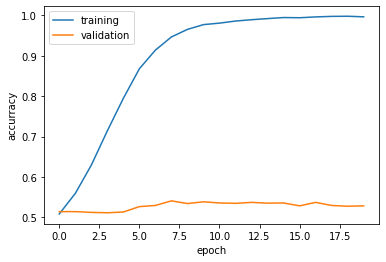

In [131]:
from matplotlib import pyplot as plt
plt.plot(log['epoch_acc'])
plt.plot(log['valid_acc'])
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.ylabel('accurracy')

In [132]:
fake_labels = [1] * len(tokenized_test1)
test_dataset = Task2Dataset_BiLSTM(vectorized_test1, vectorized_test2, fake_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)


def create_submission_file(test_loader):
    # Get results
    results  = np.array([])
    for batch in test_loader:
      X1, X2, target = batch
      X1, X2, target = X1.to(device), X2.to(device), target.to(device)
      model.batch_size = target.shape[0]
      predictions = model(X1, X2).squeeze(1)
      batch_results = np.argmax(predictions.detach().cpu().numpy(), axis=1)
      results = np.concatenate((results, batch_results))

    #Create data
    ids = test_df['id']
    results = results + 1
    results = results.astype(int)

    data = {'id': ids, 
            'pred': results}
    df = pd.DataFrame(data, columns=['id', 'pred'])

    #Export data to csv
    compression_opts = dict(method='zip',archive_name='task-2-output-part2_best.csv') 
    df.to_csv('task-2-output-part2_best.zip', index=False, compression=compression_opts)
    return

create_submission_file(test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
train_and_dev = train_df['edit1']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit1'], train_df['label'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
naive_model = MultinomialNB().fit(train_counts, training_y)

# Train predictions
predicted_train = naive_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = naive_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")

sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)

#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + 1  # 1 is most common class
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, torch.tensor(dev_y.values), True)